# Film Review

In [31]:
# -*- coding: utf-8 -*-
import os
import re
import numpy as np
import tensorflow as tf
from os import listdir

tf.reset_default_graph()

train_pos = "movie_review/train/pos/"
train_neg = "movie_review/train/neg/"
test_pos = "movie_review/test/pos/"
test_neg = "movie_review/test/neg/"

epochs = 17
batch_size = 64
max_sequence_length = 150
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005

text_data_target=[]
text_data_train=[]
test_target=[]
test_data=[]


def read_data(path):
    directory = os.fsencode(path)
    data=[]
    files = listdir(directory)
    for file in files:
        filename = os.fsdecode(file)
        with open(os.path.join(path, filename), 'r') as f:
            data.append(f.read())
    return data

#讀檔
train_pos_data = read_data(train_pos)
train_neg_data = read_data(train_neg)
test_pos_data = read_data(test_pos)
test_pos_data = read_data(test_neg)

#for i in range(2):
#    print('i = {} \ntext_data_target: {} \ntext_data_train: {}'.format(i, text_data_target[i], text_data_train[i]))

# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return(text_string)

#清理文字
train_pos_data = [clean_text(x) for x in train_pos_data]
train_neg_data = [clean_text(x) for x in train_neg_data]
test_pos_data = [clean_text(x) for x in test_pos_data]
test_neg_data = [clean_text(x) for x in test_neg_data]

#label做one-hot encoding
train_pos_target = np.ones( (len(train_pos_data),1), dtype=np.int32 )
train_neg_target = np.zeros( (len(train_pos_data),1), dtype=np.int32 )
test_pos_target = np.ones( (len(test_pos_data),1), dtype=np.int32 )
test_neg_target = np.zeros( (len(test_pos_data),1), dtype=np.int32 )

train_target = np.concatenate((train_pos_target,train_neg_target), axis=0)
test_target = np.concatenate((test_pos_target,test_neg_target), axis=0)

#資料合併，轉成字id(要把train, test data合併，一起轉成code後再分開，loss才會下降，不能分開轉)
all_data = np.concatenate((train_pos_data,train_neg_data,test_pos_data,test_neg_data), axis=0)

#轉字id
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
all_data = np.array(list(vocab_processor.fit_transform(all_data)))

#8/2分
train_data,test_data = np.split(all_data_pd, 2, axis=0)

#shuffle
shuffled_ix = np.random.permutation(np.arange(len(train_target)))
x_train = train_data[shuffled_ix]
y_train = train_target[shuffled_ix]
y_train  = y_train.reshape((len(y_train),))

shuffled_ix = np.random.permutation(np.arange(len(test_target)))
x_test = test_data[shuffled_ix]
y_test = test_target[shuffled_ix]
y_test  = y_test.reshape((len(y_test),))

vocab_size = 28685

# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])
dropout_keep_prob = tf.placeholder(tf.float32)

# Create embedding
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))  #look up table
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)                         #wordvector

#建RNN cell
#cell = tf.nn.rnn_cell.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size) for _ in range(2)])
#cell=tf.contrib.rnn.BasicRNNCell(num_units = rnn_size)
cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True)
#cell = tf.contrib.rnn.GRUCell(rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)              #連接起來
output = tf.nn.dropout(output, dropout_keep_prob)                                        #可不加

# Get output of RNN sequence
output = tf.unstack(tf.transpose(output, [1,0,2]))
last = output[-1]                                                                        

#最後一個狀態拿出來(last)，做wx+b
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output) # logits=float32, labels=int32
loss = tf.reduce_mean(losses)
train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))


with tf.Session() as sess:
    tf.global_variables_initializer().run()

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    # Start training
    for epoch in range(epochs):

        # Shuffle training data
        #shuffled_ix = np.random.permutation(np.arange(len(x_train)))
        #x_train = x_train[shuffled_ix]
        #y_train = y_train[shuffled_ix]
        
        num_batches = int(len(x_train)/batch_size) + 1
        # TO DO CALCULATE GENERATIONS ExACTLY
        for i in range(num_batches):
            
            #load一個批次
            min_ix = i * batch_size
            max_ix = np.min([len(x_train), ((i+1) * batch_size)])
            x_train_batch = x_train[min_ix:max_ix]
            y_train_batch = y_train[min_ix:max_ix]

            # Run train step
            train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
            sess.run(train_step, feed_dict=train_dict)

        # Run loss and accuracy for training
        temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
        train_loss.append(temp_train_loss)
        train_accuracy.append(temp_train_acc)

        # Run Eval Step
        test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
        temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
        test_loss.append(temp_test_loss)
        test_accuracy.append(temp_test_acc)
        print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))


    

Epoch: 1, Test Loss: 0.69, Test Acc: 0.51
Epoch: 2, Test Loss: 0.69, Test Acc: 0.52
Epoch: 3, Test Loss: 0.69, Test Acc: 0.53
Epoch: 4, Test Loss: 0.68, Test Acc: 0.59
Epoch: 5, Test Loss: 0.64, Test Acc: 0.66
Epoch: 6, Test Loss: 0.6, Test Acc: 0.69
Epoch: 7, Test Loss: 0.57, Test Acc: 0.72
Epoch: 8, Test Loss: 0.54, Test Acc: 0.74
Epoch: 9, Test Loss: 0.51, Test Acc: 0.76
Epoch: 10, Test Loss: 0.5, Test Acc: 0.77
Epoch: 11, Test Loss: 0.48, Test Acc: 0.79
Epoch: 12, Test Loss: 0.47, Test Acc: 0.79
Epoch: 13, Test Loss: 0.46, Test Acc: 0.8
Epoch: 14, Test Loss: 0.45, Test Acc: 0.81
Epoch: 15, Test Loss: 0.44, Test Acc: 0.81
Epoch: 16, Test Loss: 0.44, Test Acc: 0.81
Epoch: 17, Test Loss: 0.44, Test Acc: 0.81


# Word2Vect

In [39]:
from __future__ import print_function
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

filename='romance_condor_heroes.txt'
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    data = [ch for ch in open(filename).read() if ch != '\n' if ch != ' ']
    return data

words = read_data(filename)
print(words[:100])
print('Data size %d' % len(words))

vocabulary_size = 50000

#產生data, count, dictionary, reverse_dictionary
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)#dictionary：轉成字id
print('Most common words (+UNK)', count[:5])                      #UNK罕見字
print('Sample data', data[:10])                                   #一句話，用字id表示
del words  # Hint to reduce memory.



['“', '越', '女', '采', '蓮', '秋', '水', '畔', '，', '窄', '袖', '輕', '羅', '，', '暗', '露', '雙', '金', '釧', '。', '照', '影', '摘', '花', '花', '似', '面', '，', '芳', '心', '只', '共', '絲', '爭', '亂', '。', '雞', '尺', '溪', '頭', '風', '浪', '晚', '，', '霧', '重', '煙', '輕', '，', '不', '見', '來', '時', '伴', '。', '隱', '隱', '歌', '聲', '歸', '棹', '遠', '，', '離', '愁', '引', '著', '江', '南', '岸', '。', '”', '一', '陣', '輕', '柔', '婉', '轉', '的', '歌', '聲', '，', '飄', '在', '煙', '水', '蒙', '蒙', '的', '湖', '面', '上', '。', '歌', '聲', '發', '自', '一', '艘', '小']
Data size 948199
Most common words (+UNK) [['UNK', 0], ('，', 70583), ('。', 21619), ('一', 15645), ('不', 14690)]
Sample data [6, 269, 42, 1005, 1877, 1897, 429, 1513, 1, 1924]


In [33]:
data_index = 0

#產生training pairs
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    

data: ['“', '越', '女', '采', '蓮', '秋', '水', '畔']

with num_skips = 2 and skip_window = 1:
    batch: ['越', '越', '女', '女', '采', '采', '蓮', '蓮']
    labels: ['女', '“', '越', '采', '蓮', '女', '采', '秋']

with num_skips = 4 and skip_window = 2:
    batch: ['女', '女', '女', '女', '采', '采', '采', '采']
    labels: ['越', '蓮', '“', '采', '秋', '蓮', '越', '女']


In [34]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.                         隱藏層word vector大小
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.                   #sample softmax:不是答案的要取64個出來

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    #embeddings:橘色W(look up table)
    embeddings = tf.Variable(                                              
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    #sample softmax要用
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    #embed:紅色向量(word vector)
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)              
    
    # sampled softmax loss
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))  #向量長度
    normalized_embeddings = embeddings / norm                                #單位向量
    valid_embeddings = tf.nn.embedding_lookup(                               #紅色字向量
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    #cos值，已經單位化了所以不用再除以兩個向量長度
    
    

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [40]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        
        #產生training pairs
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
              # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        '''
        #算附近鄰居有哪些
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
        '''
    final_embeddings = normalized_embeddings.eval()
    
    

Initialized
Average loss at step 0: 7.677350
Average loss at step 2000: 3.827825
Average loss at step 4000: 3.074365
Average loss at step 6000: 2.992177
Average loss at step 8000: 2.872288
Average loss at step 10000: 2.823430
Average loss at step 12000: 2.800838
Average loss at step 14000: 2.817418
Average loss at step 16000: 2.683602
Average loss at step 18000: 2.625001
Average loss at step 20000: 2.666115
Average loss at step 22000: 2.609563
Average loss at step 24000: 2.617617
Average loss at step 26000: 2.614673
Average loss at step 28000: 2.651469
Average loss at step 30000: 2.595943
Average loss at step 32000: 2.535938
Average loss at step 34000: 2.583386
Average loss at step 36000: 2.532080
Average loss at step 38000: 2.538040
Average loss at step 40000: 2.549985
Average loss at step 42000: 2.574652
Average loss at step 44000: 2.550331
Average loss at step 46000: 2.479648
Average loss at step 48000: 2.537626
Average loss at step 50000: 2.504558
Average loss at step 52000: 2.4898

In [41]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])



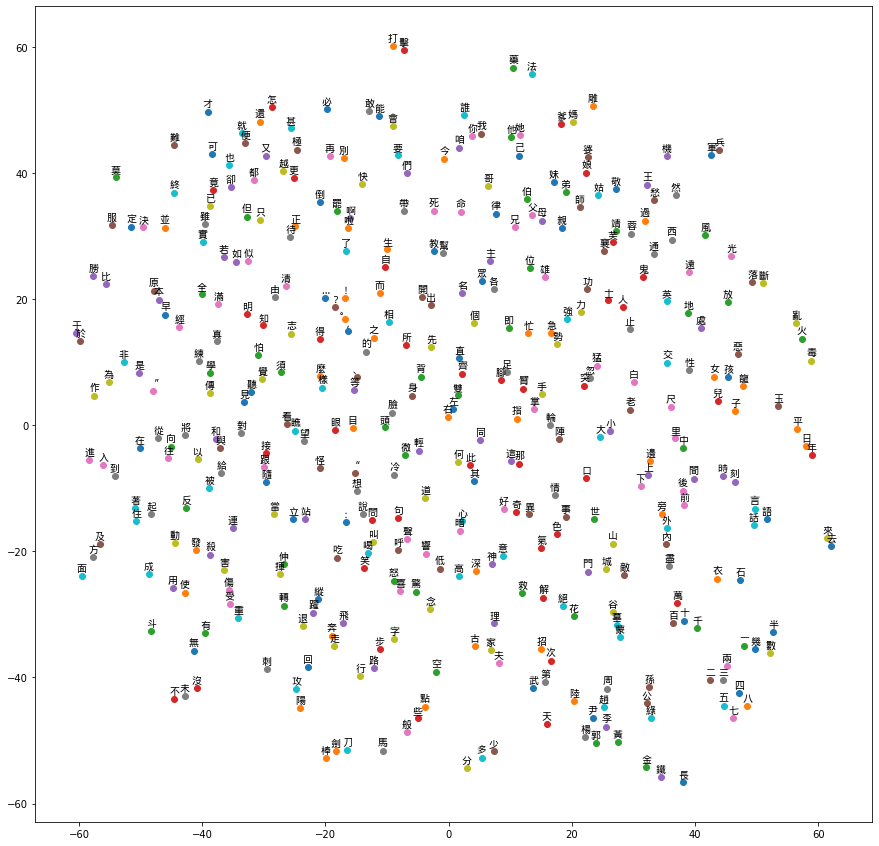

In [42]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname='DroidSansFallbackFull.ttf')                        #引入中文字

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                        ha='right', va='bottom',fontproperties=myfont)
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]

plot(two_d_embeddings, words)

